In [1]:
from analyze import run_all

sim_result = run_all()

/Users/dsyoon/STATS 607/Studio7/dgp.py:85: RuntimeWarning: divide by zero encountered in matmul
  y = beta0 + X.values @ beta + errors
/Users/dsyoon/STATS 607/Studio7/dgp.py:85: RuntimeWarning: overflow encountered in matmul
  y = beta0 + X.values @ beta + errors
/Users/dsyoon/STATS 607/Studio7/dgp.py:85: RuntimeWarning: invalid value encountered in matmul
  y = beta0 + X.values @ beta + errors
/Users/dsyoon/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dsyoon/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dsyoon/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dsyoon/STATS 607/Studio7/dgp.py:85: RuntimeWarning: divide by zero encountered in matmul
  y = beta0 + X.values @ beta + errors
/Users/ds

In [2]:
print(sim_result)

     model distribution  df_t correlation_structure  snr  aspect_ratio  n_sim  \
0      OLS       normal   NaN              identity    1           0.2    100   
1    Huber       normal   NaN              identity    1           0.2    100   
2      LAD       normal   NaN              identity    1           0.2    100   
3      OLS       normal   NaN              identity    1           0.5    100   
4    Huber       normal   NaN              identity    1           0.5    100   
..     ...          ...   ...                   ...  ...           ...    ...   
265  Huber            t  20.0        autoregressive   10           0.5    100   
266    LAD            t  20.0        autoregressive   10           0.5    100   
267    OLS            t  20.0        autoregressive   10           0.8    100   
268  Huber            t  20.0        autoregressive   10           0.8    100   
269    LAD            t  20.0        autoregressive   10           0.8    100   

           MSE      MCSE  


/var/folders/g6/3hhyn8197wv_9qkbbq8ccjgw0000gn/T/ipykernel_31165/1569209820.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(["model", "snr", "aspect_ratio", "df_t_plot"], as_index=False)


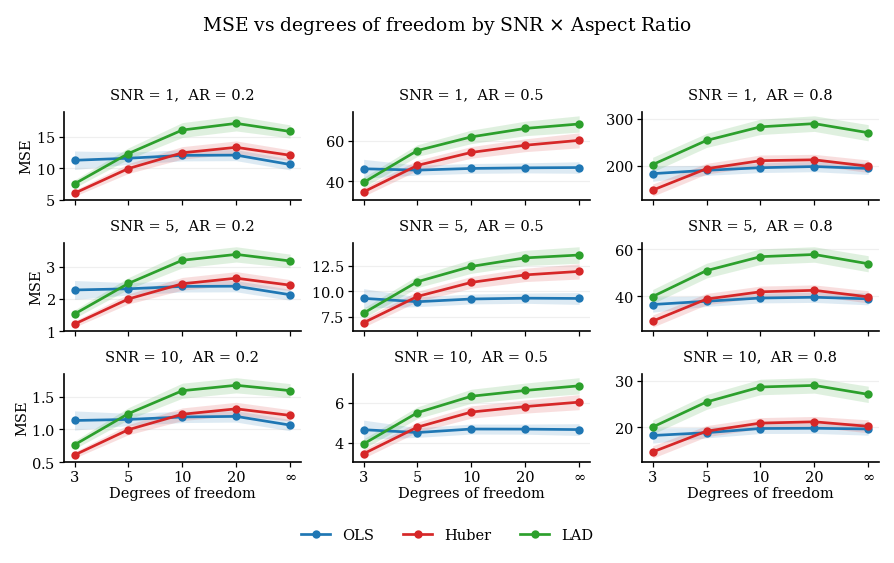

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ---------------------------
# Compact, publication-style settings
# ---------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.dpi": 150,
    "text.usetex": False,      # ensures all text uses the same font renderer
})

# Assume sim_result already exists
df = sim_result.copy()

# Map distribution=normal → df_t = ∞
df["df_t_plot"] = df["df_t"].copy()
df.loc[df["distribution"] == "normal", "df_t_plot"] = np.inf

x_order = [3, 5, 10, 20, np.inf]
x_pos_map = {v: i for i, v in enumerate(x_order)}
x_labels = ["3", "5", "10", "20", "∞"]

# Aggregate MSE + MCSE
def combine_means_and_ses(group):
    m = group["MSE"].mean()
    k = len(group)
    se = np.sqrt(np.sum((group["MCSE"].values ** 2) * (1.0 / k) ** 2))
    return pd.Series({"MSE_mean": m, "SE_comb": se})

df_comb = (
    df.groupby(["model", "snr", "aspect_ratio", "df_t_plot"], as_index=False)
      .apply(combine_means_and_ses)
)

models = ["OLS", "Huber", "LAD"]
colors = {"OLS": "#1f77b4", "Huber": "#d62728", "LAD": "#2ca02c"}
snr_list = [1, 5, 10]
ar_list = [0.2, 0.5, 0.8]

# Figure size ≈ 6" × 3.5"
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 3.5), sharex=True, sharey=False)
fig.suptitle("MSE vs degrees of freedom by SNR $\\times$ Aspect Ratio", fontsize=9)

for i, snr in enumerate(snr_list):
    for j, ar in enumerate(ar_list):
        ax = axes[i, j]
        dsub = df_comb[(df_comb["snr"] == snr) & (df_comb["aspect_ratio"] == ar)]

        for model in models:
            dm = dsub[dsub["model"] == model]

            xs, ys, ses = [], [], []
            for dft in x_order:
                row = dm[dm["df_t_plot"] == dft]
                if len(row) > 0:
                    xs.append(x_pos_map[dft])
                    ys.append(row["MSE_mean"].values[0])
                    ses.append(row["SE_comb"].values[0])
            if not xs:
                continue

            xs, ys, ses = np.array(xs), np.array(ys), np.array(ses)

            # 95% CI ribbon
            ax.fill_between(xs, ys - 1.96 * ses, ys + 1.96 * ses,
                            alpha=0.15, linewidth=0, color=colors[model])

            # Mean line
            ax.plot(xs, ys, marker="o", markersize=3, linewidth=1.3,
                    label=model, color=colors[model])

        # Clean typographic titles (no math font, same font as axes)
        ax.set_title(f"SNR = {snr},  AR = {ar}", fontsize=7)

        # Axis formatting
        if i == 2:
            ax.set_xticks(range(len(x_order)))
            ax.set_xticklabels(x_labels, fontsize=7)
            ax.set_xlabel("Degrees of freedom", fontsize=7, labelpad=1)
        else:
            ax.set_xticks(range(len(x_order)))
            ax.set_xticklabels([])

        if j == 0:
            ax.set_ylabel("MSE", fontsize=7, labelpad=1)

        # Minimal, subtle gridlines
        ax.yaxis.grid(True, which="major", alpha=0.2, linewidth=0.6)
        ax.xaxis.grid(False)
        ax.tick_params(length=2.5, width=0.6, pad=1.5)

        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.get_major_formatter().set_scientific(False)

# Unified legend with consistent font
handles, labels = axes[0, 0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=7,
                 bbox_to_anchor=(0.5, -0.05))
for lh in leg.legend_handles:
    lh.set_linewidth(1.3)

plt.tight_layout(rect=[0, 0.02, 1, 0.95], w_pad=0.6, h_pad=0.6)
plt.show()